In [23]:
# 09-17-24 works with analysisData_091724.csv

import pandas as pd

# Load the tab-delimited text file into a DataFrame
# filepath = "/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham leak analysis/scripts/matlab-copy/August 2024/analysisData.csv"
# df = pd.read_csv(filepath, sep='\t')
# filepath = '/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham leak analysis/scripts/matlab-copy/September 2024/analysisData_091724.csv'
filepath = '/Users/jcoleman/Documents/--LARGE DATA--/#Pizzi/TBI-sham leak analysis/scripts/matlab-copy/August 2024/analysisData_063025.csv'
# # Print the first few rows of the DataFrame
# print(df.head())

In [24]:
# Add these steps for '*CapLogicals' 'Near' and 'Far' vs Z data
# Load the CSV file into a DataFrame
df = pd.read_csv(filepath)

# Get column headers containing the substring
# TEST:
# substring =  'midCap' # 'preL'#, 'pstL', 'midCap'
# matching_headers = df.columns[df.columns.str.contains(substring)]
# Print the matching headers
# print(matching_headers)



In [25]:
# Load the CSV file into a DataFrame
df = pd.read_csv(filepath)

# Filter the DataFrame where 'group' is 'A'
filtered_df_A = df[df['group'] == 'A']
# Filter the DataFrame where 'group' is 'A'
filtered_df_B = df[df['group'] == 'B']

# Display the filtered DataFrame
#print(filtered_df_A.head())
print(filtered_df_A['filename'])
print(filtered_df_A['group'])
print(filtered_df_B['filename'])
print(filtered_df_B['group'])

0     ZT10_16X6x_gg_800nm_m5_roi2_00003_ROIs_classA
1     ZT10_16X6x_gg_800nm_m6_roi1_00001_ROIs_classA
3     ZT10_16X6x_gg_800nm_m9_roi1_00002_ROIs_classA
4    ZT10_16X6x_gg_800nm_m10_roi1_00001_ROIs_classA
5    ZT10_16X6x_gg_800nm_m11_roi1_00001_ROIs_classA
6    ZT10_16X6x_gg_800nm_m12_roi1_00001_ROIs_classA
Name: filename, dtype: object
0    A
1    A
3    A
4    A
5    A
6    A
Name: group, dtype: object
2     ZT10_16X6x_gg_800nm_m7_roi1_00001_ROIs_classA
7    ZT10_16X6x_gg_800nm_m13_roi1_00002_ROIs_classA
8    ZT10_16X6x_gg_800nm_m15_roi1_00001_ROIs_classA
9    ZT10_16X6x_gg_800nm_m16_roi1_00001_ROIs_classA
Name: filename, dtype: object
2    B
7    B
8    B
9    B
Name: group, dtype: object


In [26]:
# extract a single metric
def filter_dataframe_single(df, metric_prefix, logical_prefix, group):
    """
    Filters the DataFrame to return rows for a specific group and metric columns 
    based on corresponding logical columns being 1.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame.
    metric_prefix (str): The prefix for columns representing metrics (e.g., 'meanFWHM').
    logical_prefix (str): The prefix for columns representing logicals (e.g., 'capLogical').
    group (str): The group ID (e.g., 'A', 'B') for row filtering.

    Returns:
    pd.DataFrame: A filtered DataFrame based on the group and corresponding metrics.
    """
    # Filter rows based on the group
    filtered_df = df[df['group'] == group]

    # Get metric and logical columns
    metric_columns = [col for col in df.columns if col.startswith(metric_prefix)]
    logical_columns = [col for col in df.columns if col.startswith(logical_prefix)]

    # Create a list to store valid metric columns based on logical conditions
    valid_columns = []

    # For each metric/logical column pair, check if logical column is 1
    for metric_col, logical_col in zip(metric_columns, logical_columns):
        # Check if the logical column has 1s in the rows we're working with
        if (filtered_df[logical_col] == 1).any():
            valid_columns.append(metric_col)  # If yes, add the corresponding metric column

    # Return the filtered DataFrame with only valid metric columns and group
    return filtered_df[valid_columns + ['group']]

# Example usage
# df = pd.read_csv('your_file.csv')
# filtered_result_Acap = filter_dataframe_single(df, 'meanFWHM', 'capLogical', 'A')
# print(filtered_result_Acap.head())

In [27]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr
import numpy as np

def filter_dataframe(df, metric_prefix, second_metric_prefix, logical_prefix, group):
    """
    Filters the DataFrame to return rows for a specific group and metric columns 
    based on corresponding logical columns being 1.

    Parameters:
    df (pd.DataFrame): The input DataFrame.
    metric_prefix (str): The prefix for the first metric column (e.g., 'meanFWHM').
    second_metric_prefix (str): The prefix for the second metric column to plot against.
    logical_prefix (str): The prefix for columns representing logicals (e.g., 'capLogical').
    group (str): The group ID (e.g., 'A', 'B') for row filtering.

    Returns:
    pd.DataFrame: A filtered DataFrame with the two metrics and group columns.
    """
    # Filter rows based on the group
    filtered_df = df[df['group'] == group]

    # Get metric and logical columns
    metric_columns = [col for col in df.columns if col.startswith(metric_prefix)]
    second_metric_columns = [col for col in df.columns if col.startswith(second_metric_prefix)]
    logical_columns = [col for col in df.columns if col.startswith(logical_prefix)]

    # Create a list to store valid metric columns based on logical conditions
    valid_metric_columns = []
    valid_second_metric_columns = []

    # For each metric/logical column pair, check if logical column is 1
    for metric_col, logical_col in zip(metric_columns, logical_columns):
        if (filtered_df[logical_col] == 1).any():
            valid_metric_columns.append(metric_col)

    # Use the same logic to keep second metric columns aligned
    for second_metric_col, logical_col in zip(second_metric_columns, logical_columns):
        if (filtered_df[logical_col] == 1).any():
            valid_second_metric_columns.append(second_metric_col)

    # Return the filtered DataFrame with the two valid metric columns and group
    return filtered_df[valid_metric_columns + valid_second_metric_columns + ['group', 'filename']]


def scatter_plot_with_stats(df, metric_prefix, second_metric_prefix, logical_prefix, group, xlow,xhigh,ylow,yhigh):
    """
    Plots a scatter plot of two metrics (with the same prefix) across multiple columns,
    handling NaN values, and calculates regression stats (r², p-value, Pearson correlation).
    
    Parameters:
    df (pd.DataFrame): The filtered DataFrame with multiple metric columns.
    metric_prefix (str): The first metric prefix (e.g., 'meanFWHM') for the x-axis.
    second_metric_prefix (str): The second metric prefix (e.g., 'meanFeFv') for the y-axis.
    group (str): The group ID to include in the plot (e.g., 'A' or 'B').
    """
    # Extract columns that start with the given prefixes
    metric_columns = [col for col in df.columns if col.startswith(metric_prefix)]
    second_metric_columns = [col for col in df.columns if col.startswith(second_metric_prefix)]

    # Concatenate all metric columns into single arrays for plotting
    x_vals = pd.concat([df[metric] for metric in metric_columns], axis=0)
    y_vals = pd.concat([df[second_metric] for second_metric in second_metric_columns], axis=0)
    filenames = pd.concat([df['filename']] * len(metric_columns), axis=0)

    # Remove rows where either x or y is NaN
    valid_indices = (~x_vals.isna()) & (~y_vals.isna())
    x_vals = x_vals[valid_indices]
    y_vals = y_vals[valid_indices]
    filenames = filenames[valid_indices]

    # Scatter plot
    plt.figure(figsize=(8, 6))
    #sns.scatterplot(x=x_vals, y=y_vals, hue=filenames, style=filenames, palette='tab10')
    sns.scatterplot(x=x_vals, y=y_vals, hue=filenames, marker='o', palette='tab10')

    # Calculate statistics: Pearson correlation, p-value, and r²
    if len(x_vals) > 1 and len(y_vals) > 1:
        pearson_corr, p_value = pearsonr(x_vals, y_vals)
        r_squared = pearson_corr ** 2
        # Display stats on the plot
        stats_text = f"Pearson's r: {pearson_corr:.2f}\n" \
                     f"p-value: {p_value:.3e}\n" \
                     f"r²: {r_squared:.2f}\nGroup: {group}"
        #         plt.text(0.05, 0.95, stats_text, transform=plt.gca().transAxes, fontsize=12,
        #                  verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))
        #         plt.text(1.05, -0.2, stats_text, transform=plt.gca().transAxes, 
        #          fontsize=12, verticalalignment='top', 
        #          horizontalalignment='right', 
        #          bbox=dict(facecolor='white', alpha=0.5))
        plt.text(1.30, 0.25, stats_text, transform=plt.gca().transAxes, 
         fontsize=12, verticalalignment='top', 
         horizontalalignment='right', 
         bbox=dict(facecolor='white', alpha=0.5))
    else:
        # If there are not enough valid points to calculate Pearson
        plt.text(1.30, 0.45, f"Not enough valid data points\nGroup: {group}", transform=plt.gca().transAxes,
                 fontsize=12, verticalalignment='top', bbox=dict(facecolor='white', alpha=0.5))

    # Labels and title
    # Set x-axis limits
    if xlow is not None and xhigh is not None:
        plt.xlim(xlow, xhigh)
    if ylow is not None and yhigh is not None:
        plt.ylim(ylow, yhigh)
    
    plt.xlabel(metric_prefix)
    plt.ylabel(second_metric_prefix)
    plt.title(f'Scatter Plot: {metric_prefix} vs {second_metric_prefix} (Group {group})')
    plt.suptitle(f'Scatter Plot: {metric_prefix} vs {second_metric_prefix} (Group {group})')
    plt.title(f'Vessel type: {logical_prefix}')
    #plt.legend(title='Filename')
    plt.legend(title='Filename', bbox_to_anchor=(1.05, 1), loc='upper left')
#     plt.grid(True)
    #plt.tight_layout()  # Ensure proper layout
    #return plt.gcf()  # Return the figure object
    # Save the plot as a PDF file
    plt.savefig('scatter2D_'+group+'.pdf', format='pdf', dpi=300) #, bbox_inches='tight')
    plt.show()
    
# Example usage
# df = pd.read_csv('your_file.csv')
# filtered_result = filter_dataframe(df, 'meanFWHM', 'meanFeFv', 'capLogical', 'A')
# scatter_plot_with_stats(filtered_result, 'meanFWHM', 'meanFeFv', 'A')

In [28]:
# BAR PLOT
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import sem

def plot_bar_with_sem(data1, data2, figure_filename, MetricID, font_style='Arial', font_size=12):
    
    # For example: use all 'groupA' FWHM data
    #   Each subject has one data point = the mean of all rois across subject-images)
    #     all 'm10' images/filenames and respectice roi values =>
    plt.figure(figsize=(5,5))
    # Calculate mean and SEM for each group
    mean1 = np.nanmean(data1)
    #sem1 = np.nanstd(data1) / np.nansqrt(len(data1))
    sem1 = sem(data1, nan_policy='omit')
    mean2 = np.nanmean(data2)
    #sem2 = np.std(data2) / np.sqrt(len(data2))
    sem2 = sem(data2, nan_policy='omit')

    # Plot means with error bars (SEM)
    bar_width = 0.35
    index = np.arange(2)
    #bars = plt.bar(index, [mean1, mean2], bar_width, yerr=[sem1, sem2], color=['blue', 'green'], alpha=0.1)
    #bars = plt.bar(index, [mean1, mean2], bar_width, yerr=[sem1, sem2], color=['white', 'white'], edgecolor=['blue', 'green'], linewidth=1.0, alpha=1.0, zorder=1)
    bars = plt.bar(index, [mean1, mean2], bar_width, yerr=[sem1, sem2], color=['white', 'white'], edgecolor=['black', 'red'], linewidth=1.0, alpha=1.0, zorder=1)

    
    # Overlay scatterplot data for each group (NEEDS LOOP COLOR)
    for i, data in enumerate([data1, data2]):
        # Set color LUT
        #dotcolors = ['blue', 'green']
        dotcolors = ['black', 'red']
        # Generate random x-offset values for scatterplot
        x_offset = np.random.uniform(-0.1, 0.1, size=len(data))
        # Generate X values for scatterplot (group index with random offset)
        x_values = index[i] + x_offset
        #plt.scatter(x_values, data, facecolors=dotcolors[i], edgecolors=dotcolors[i], linewidths=0.5, alpha=1.0, zorder=3)  # Overlay scatterplot for each group
        plt.scatter(x_values, data, facecolors=dotcolors[i], edgecolors=dotcolors[i], linewidths=1.0, alpha=1.0, zorder=3)  # Overlay scatterplot for each group

    # Set font style and size for all labels

    # Set font style and size for all labels
    plt.rcParams['font.family'] = font_style
    plt.rcParams['font.size'] = font_size

    plt.xlabel('Groups')
    plt.ylabel(MetricID)
    plt.xticks(index, ['Group A', 'Group B'])

    # Add legends for both groups
    plt.legend(bars, ['Group A', 'Group B'], frameon=False, loc='best')
    
    plt.title('Bar-Scatter Plot of Means ± SEM for Two Groups')
    
    # Save the plot as a TIFF file
    plt.savefig(figure_filename + '.tif', format='tiff', dpi=300)
    
    # Save the plot as a PDF file
    plt.savefig(figure_filename + '.pdf', format='pdf', dpi=300) #, bbox_inches='tight')
    
    # Save the plot as an EPS file
    plt.savefig(figure_filename + '.eps', format='eps', dpi=300) #, bbox_inches='tight')
    #plt.savefig('example_plot.tiff', format='tiff', dpi=300)

    plt.show()


In [29]:
# Define substrings you want to search for
substrings_cap = ['midCap', 'preL', 'pstL', 'Z', 'meanFeFv']  # Add more as needed

# Create a new DataFrame to store logical columns
logical_df_cap = pd.DataFrame()

# Loop over each substring and create a logical column
for substring in substrings_cap:
    matching_columns = df.columns[df.columns.str.contains(substring)]
    # Combine all matching columns for that substring using logical OR across rows
#     logical_df_cap[substring + '_logical'] = df[matching_columns].any(axis=1)

# Print result
print(matching_columns)

Index(['meanFeFv_1', 'meanFeFv_2', 'meanFeFv_3', 'meanFeFv_4', 'meanFeFv_5',
       'meanFeFv_6', 'meanFeFv_7', 'meanFeFv_8', 'meanFeFv_9', 'meanFeFv_10',
       'meanFeFv_11', 'meanFeFv_12', 'meanFeFv_13', 'meanFeFv_14',
       'meanFeFv_15', 'meanFeFv_16', 'meanFeFv_17', 'meanFeFv_18',
       'meanFeFv_19', 'meanFeFv_20', 'meanFeFv_21', 'meanFeFv_22',
       'meanFeFv_23', 'meanFeFv_24', 'meanFeFv_25', 'meanFeFv_26',
       'meanFeFv_27', 'meanFeFv_28', 'meanFeFv_29', 'meanFeFv_30',
       'meanFeFv_31', 'meanFeFv_32', 'meanFeFv_33', 'meanFeFv_34',
       'meanFeFv_35', 'meanFeFv_36', 'meanFeFv_37', 'meanFeFv_38',
       'meanFeFv_39', 'meanFeFv_40'],
      dtype='object')


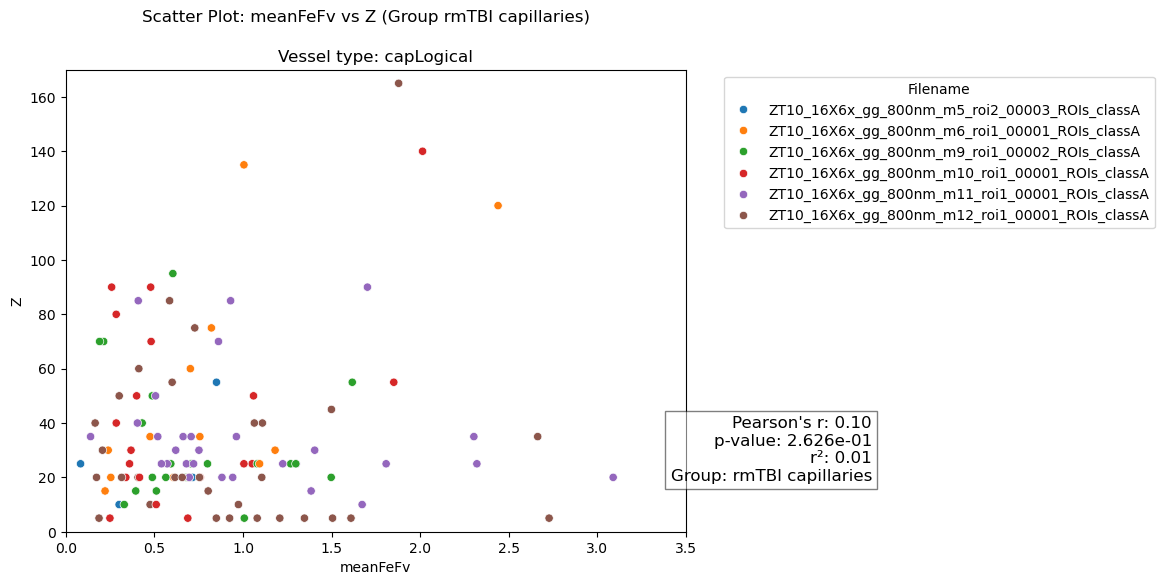

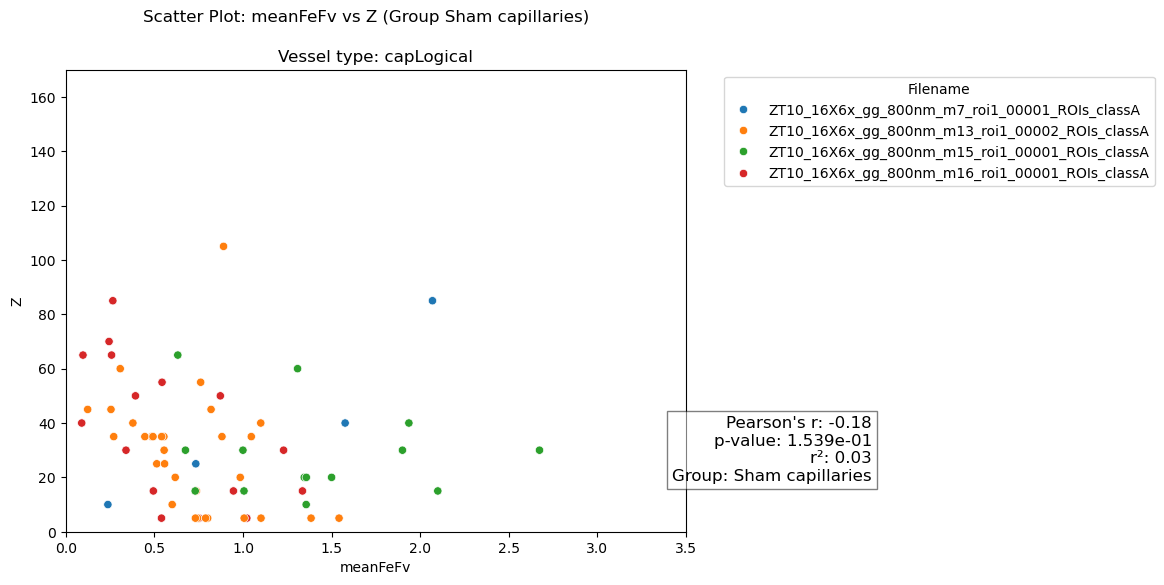

In [6]:
# get meanFeFv, Zmicrons data for 'cap'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFeFv', 'Z', 'capLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFeFv', 'Z', 'capLogical', 'rmTBI capillaries',0,3.5,0,170)


filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFeFv', 'Z', 'capLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFeFv', 'Z', 'capLogical', 'Sham capillaries',0,3.5,0,170)
# # Save the plot as a PDF file
# plt.savefig('scatter2D_Sham.pdf', format='pdf', dpi=300) #, bbox_inches='tight')

# working on printing to PDF - formatting needs fixing, but works
#  BUT need return plt.gcf()  # Return the figure object
# import matplotlib.backends.backend_pdf as mpdf

# with mpdf.PdfPages('plots.pdf') as pdf:
#     for group in ['A', 'B']:
#         filtered_result = filter_dataframe(df, 'meanFeFv', 'Z', 'capLogical', group)
#         fig = scatter_plot_with_stats(filtered_result, 'meanFeFv', 'Z', group)
#         pdf.savefig(fig)
#         plt.close(fig)

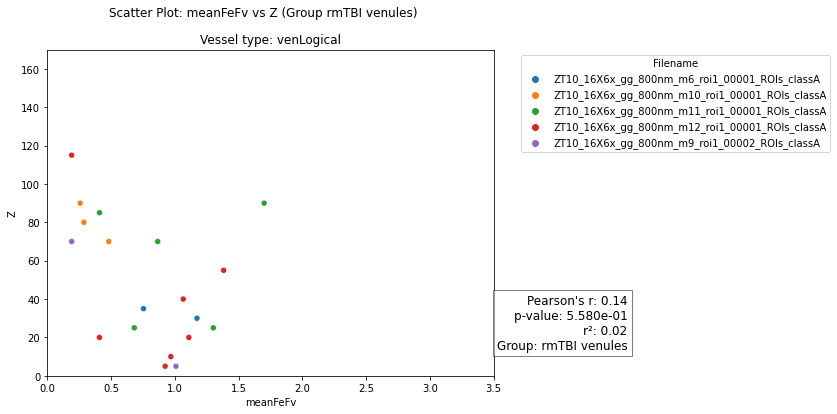

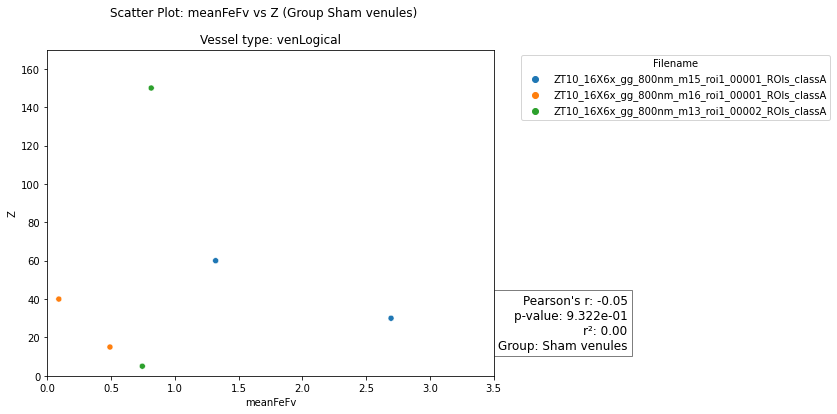

In [30]:
# get meanFeFv, Zmicrons data for 'ven'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFeFv', 'Z', 'venLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFeFv', 'Z', 'venLogical', 'rmTBI venules',0,3.5,0,170)

filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFeFv', 'Z', 'venLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFeFv', 'Z', 'venLogical', 'Sham venules',0,3.5,0,170)

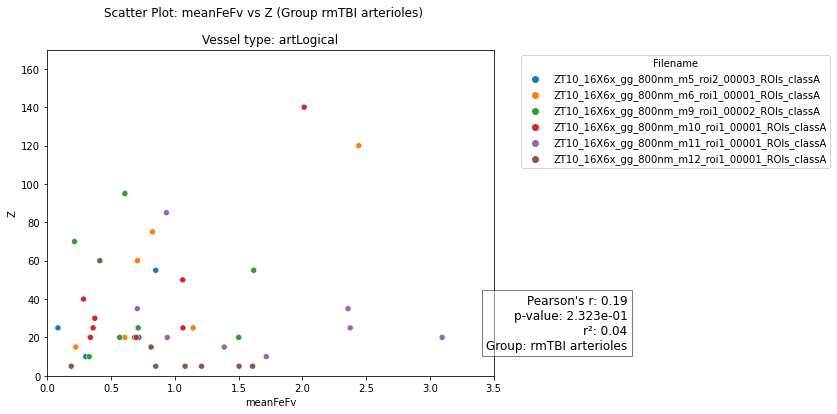

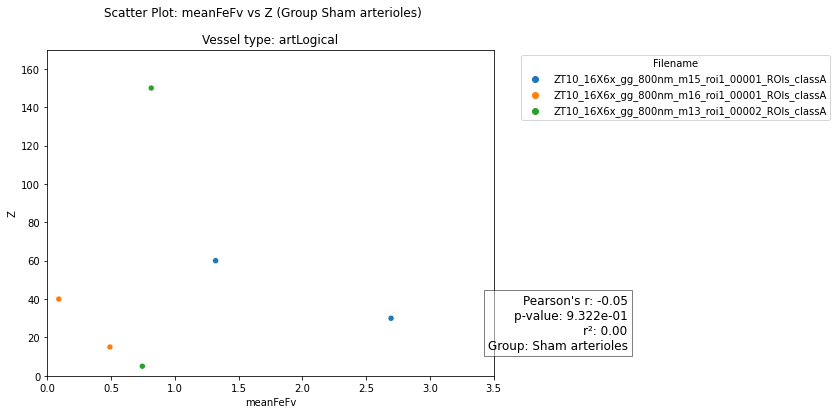

In [31]:
# get meanFeFv, Zmicrons data for 'art'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFeFv', 'Z', 'artLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFeFv', 'Z', 'artLogical', 'rmTBI arterioles',0,3.5,0,170)

filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFeFv', 'Z', 'venLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFeFv', 'Z', 'artLogical', 'Sham arterioles',0,3.5,0,170)

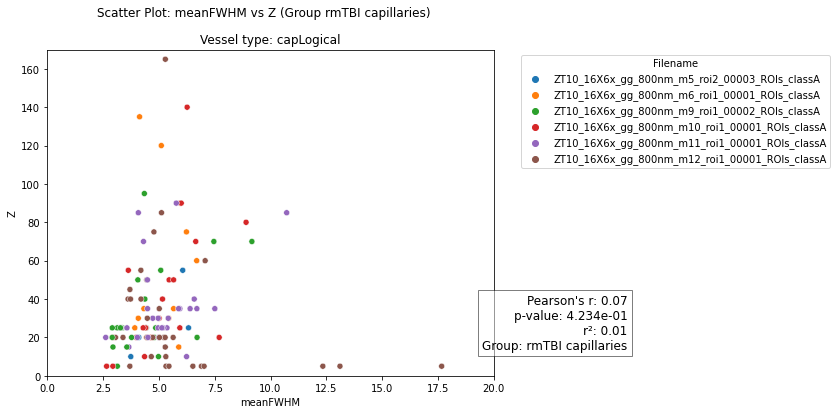

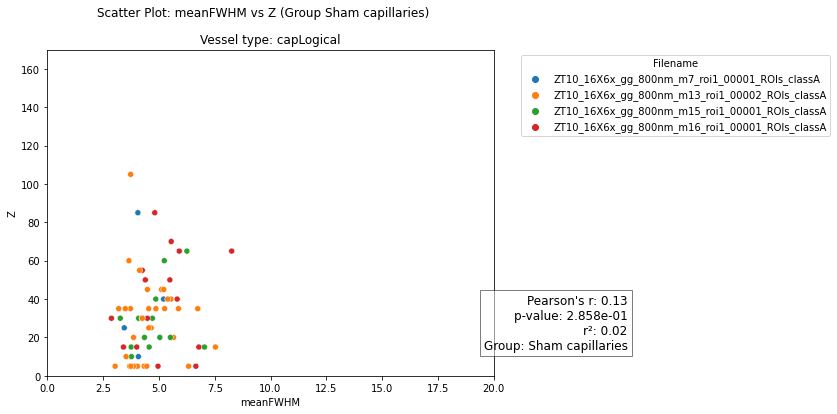

In [32]:
# get meanFWHM, Zmicrons data for 'cap'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFWHM', 'Z', 'capLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFWHM', 'Z', 'capLogical', 'rmTBI capillaries',xlow=0,xhigh=20,ylow=0,yhigh=170)

filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFWHM', 'Z', 'capLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFWHM', 'Z', 'capLogical', 'Sham capillaries',xlow=0,xhigh=20,ylow=0,yhigh=170)

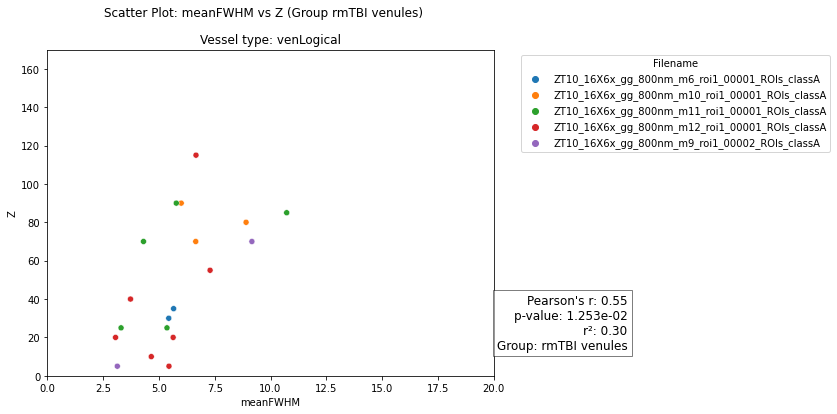

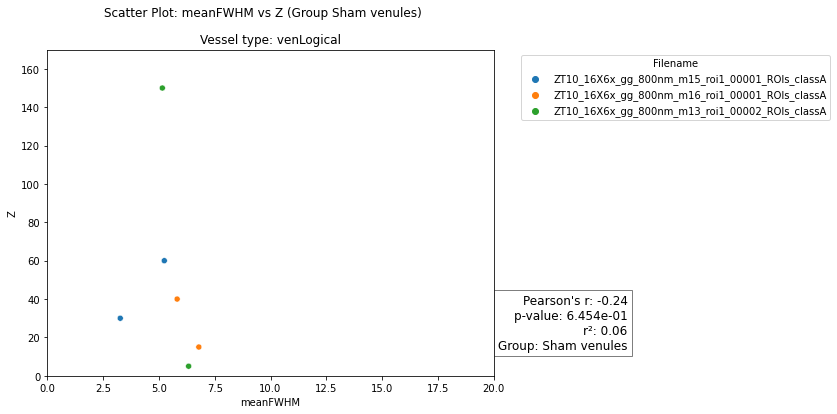

In [33]:
# get meanFWHM, Zmicrons data for 'ven'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFWHM', 'Z', 'venLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFWHM', 'Z', 'venLogical', 'rmTBI venules',xlow=0,xhigh=20,ylow=0,yhigh=170)

filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFWHM', 'Z', 'venLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFWHM', 'Z', 'venLogical', 'Sham venules',xlow=0,xhigh=20,ylow=0,yhigh=170)

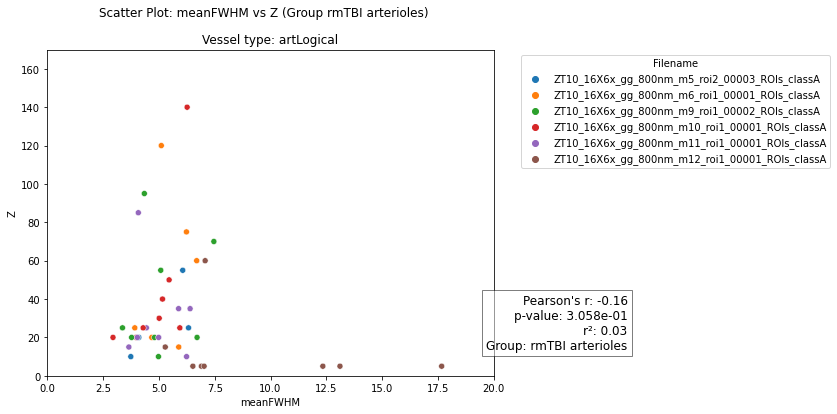

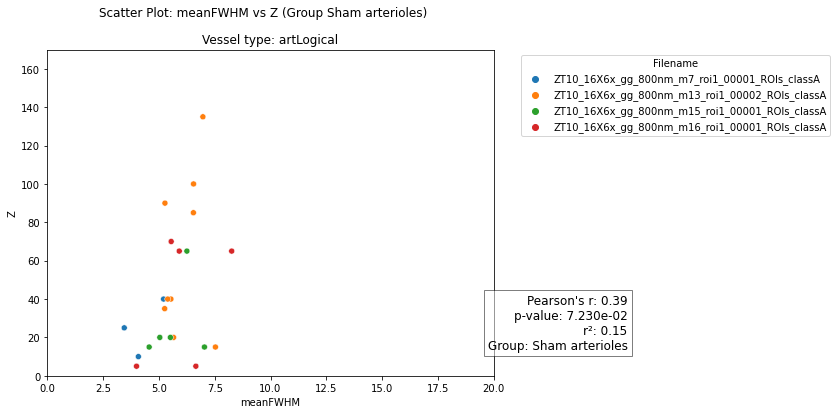

In [34]:
# get meanFWHM, Zmicrons data for 'art'
filtered_resultA = []
filtered_resultA = filter_dataframe(df, 'meanFWHM', 'Z', 'artLogical', 'A')
scatter_plot_with_stats(filtered_resultA, 'meanFWHM', 'Z', 'artLogical', 'rmTBI arterioles',xlow=0,xhigh=20,ylow=0,yhigh=170)
# ,xlow=None, xhigh=None,ylow=None,yhigh=None

filtered_resultB = []
filtered_resultB = filter_dataframe(df, 'meanFWHM', 'Z', 'artLogical', 'B')
scatter_plot_with_stats(filtered_resultB, 'meanFWHM', 'Z', 'artLogical', 'Sham arterioles',xlow=0,xhigh=20,ylow=0,yhigh=170)

In [174]:
# data for mean barplots

metric1 = 'meanFWHM'
metric2 = 'meanFeFv'

filtered_resultA = filter_dataframe(df, metric1, metric2, 'capLogical', 'A')
filtered_resultB = filter_dataframe(df, metric1, metric2, 'capLogical', 'B')

# filtered_resultA = filter_dataframe(df, metric1, metric2, 'venLogical', 'A')
# filtered_resultB = filter_dataframe(df, metric1, metric2, 'venLogical', 'B')

# filtered_resultA = filter_dataframe(df, metric1, metric2, 'artLogical', 'A')
# filtered_resultB = filter_dataframe(df, metric1, metric2, 'artLogical', 'B')

In [175]:
# PLOT cap meanFWHM or etc
# Select meanFWHM_* columns or etc
mean_cols_A = [col for col in filtered_resultA.columns if col.startswith(metric2)]
mean_cols_B = [col for col in filtered_resultB.columns if col.startswith(metric2)]

# Calculate mean for each row
data1mean = filtered_resultA[mean_cols_A].mean(axis=1)
data2mean = filtered_resultB[mean_cols_B].mean(axis=1)

# # Alternatively, using numpy
# import numpy as np
# data1mean = np.nanmean(filtered_result_capA[mean_cols], axis=1)

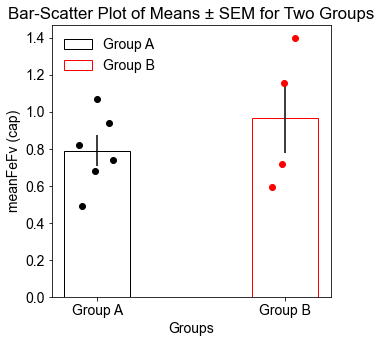

Mann-Whitney U statistic: 9.0
P-value: 0.6095238095238095
Fail to reject the null hypothesis: the distributions are not significantly different


In [176]:
# STATS cap meanFWHM
from scipy.stats import mannwhitneyu

filename_out = 'data_meanFeFv_cap_barplot_091724_2'

# # Save the plot as a TIFF file
# plt.savefig('example_plot.tiff', format='tiff', dpi=300)

# plt.show()
# metric_str = 'meanFWHM (cap)'
# metric_str = 'meanFWHM (ven)'
# metric_str = 'meanFWHM (art)'

metric_str = 'meanFeFv (cap)'
# metric_str = 'meanFeFv (ven)'
# metric_str = 'meanFeFv (art)'

plot_bar_with_sem(data1mean, data2mean, filename_out, metric_str, font_style='Arial', font_size=14)
#import numpy as np

# Example data: two vectors
# vector1 = np.random.randn(100)  # Random data for vector1
# vector2 = np.random.randn(100) + 0.5  # Random data for vector2, shifted by 0.5

# data1_clean = data1mean.dropna()
# data2_clean = data2mean.dropna()
# Perform the Mann-Whitney U test
stat, p_value = mannwhitneyu(data1mean, data2mean, alternative='two-sided')

# add results table to TXT file
textout = filename_out + '.txt'
with open(textout, 'w') as f:
    print(f'Mann-Whitney U statistic: {stat}', file=f)
    print(f'P-value: {p_value}', file=f)
    
    alpha = 0.05
    if p_value < alpha:
        print('Reject the null hypothesis: the distributions are different', file=f)
    else:
        print('Fail to reject the null hypothesis: the distributions are not significantly different', file=f)
    
# Print the results
print(f'Mann-Whitney U statistic: {stat}')
print(f'P-value: {p_value}')

# Interpret the result
alpha = 0.05
if p_value < alpha:
    print('Reject the null hypothesis: the distributions are different')
else:
    print('Fail to reject the null hypothesis: the distributions are not significantly different')